## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

There are a number of steps involved in creating an accurate predictive model as described in the project brief. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

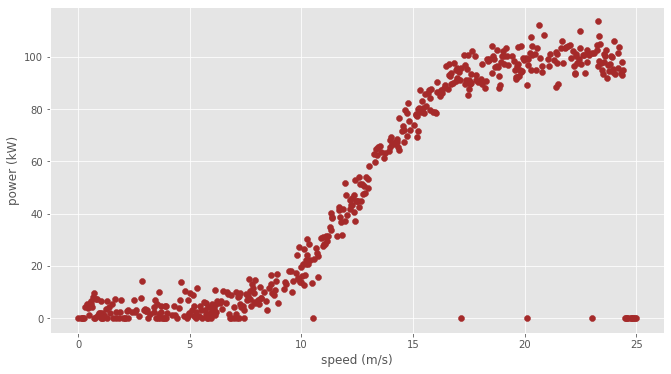

In [5]:
# Plot data on a scatter plot
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o')

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From approximate speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This is something which will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

*Function approximation* is the term used to describe the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` model will be applied to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to detect any outliers in order to improve the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

When training a predictive model, it is important to remove any outliers so that the data we train the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13].

Prior to removing any identified outliers, let us first see how a simple linear regression model performs with the orignial data set. The data is split into training and testing data. This procedure is explored and explained in greater detail below:

In [106]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Create model
reg_pp = LinearRegression()

# Fit model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value
score_pp = reg_pp.score(A_Test_pp, B_Test_pp)

# Print score
print(score_pp)

0.7196585822445968


Training the model using the full data set yields a score of ~0.74. This represents the R-Squared value of the model. 

<br>

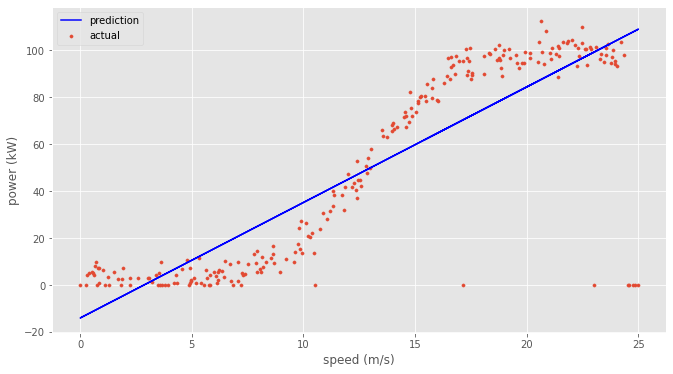

In [107]:
# Use model to make predictions
pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

#### 3.1.2 Outlier detection and removal

As we saw above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appear to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. This function returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [8]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [124]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed in the scatterplot. Below, I remove them from the data set, creating an updated data set `pp_clean` in the process:

In [125]:
# Remove outliers from data set
pp_clean = pp.drop(outliers_mahal_rob)

In [126]:
# Output statistical summary of updated data frame
pp_clean.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


Text(0, 0.5, 'power (kW)')

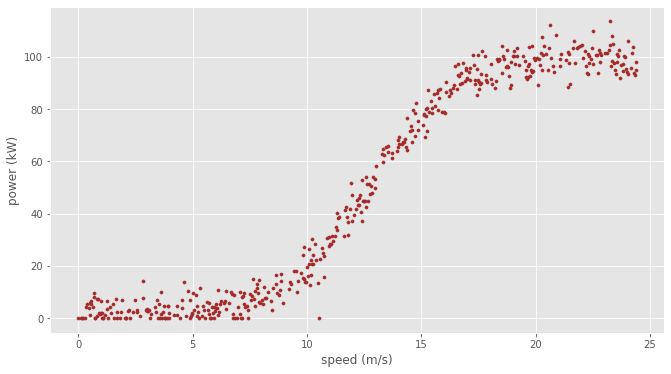

In [127]:
plt.scatter(pp_clean['speed'], pp_clean['power'], color='brown', marker='o', s=10)
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')

The Mahalonibis Distance function detected all but one outlier. I will remove this too for improved performance. Firstly, we view the last 5 observations with power = 0kW:


In [128]:
pp_zero = pp_clean.loc[pp_clean['power'] == 0]
pp_zero.tail()

,speed,power
135,6.857,0.0
136,6.957,0.0
140,7.107,0.0
149,7.432,0.0
208,10.511,0.0


We can see that the outlier is at index 208. This can be removed with the following code:

In [129]:
pp_updated = pp_clean.drop([208])

Now we can train the model with the updated data set:

In [141]:
# Using original (pp) data set to train model 
speed_df_pp_clean = pp_updated.drop('power',axis='columns')
power_df_pp_clean = pp_updated.drop('speed',axis='columns')

# Train test split
x_train, x_test, y_train, y_test = train_test_split(speed_df_pp_clean, power_df_pp_clean, test_size = 0.5, random_state=1)

# Create model
reg_pp_clean = LinearRegression()

# Fit model
reg_pp_clean.fit(x_train, y_train)

# Calculate R-squared value
score_pp_clean = reg_pp_clean.score(x_test, y_test)

# Print score
print(score_pp_clean)

0.9008406364589567


Once the outliers are removed, the model performs better. It yields a score of ~0.90. 

<br>

We can plot both models side by side for visual comparison:

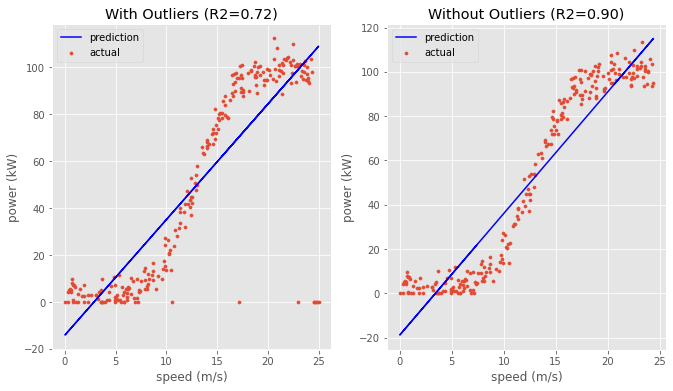

In [142]:
# First subplot
plt.subplot(1, 2, 1)
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('With Outliers (R2=0.72)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)

# Call predict method on test data and plot resulting line
pp_updated_predict = reg_pp_clean.predict(x_test)

plt.scatter(x_test, y_test, label='actual', s=10)
plt.plot(x_test, pp_updated_predict, label='prediction', color='b')

plt.title('Without Outliers (R2=0.90)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

When viewed side by side, we see that once the outliers are removed the line is a slightly better fit, although it is clear that a straight line does not manage to capture the data accurately in either model.

<br>

#### 3.1.3 Train-test split

This section provides a brief explanation of the *train-test split* procedure as performed in the previous section.

The goal of this project is to accurately predict wind turbine power output from wind speed values. Indeed, it is the aim of any predictive model to maximise the accuracy of model output. In machine learning, *evaluation* and *validation* are key aspects in measuring how accurate a model is in this regard [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice in supervised machine learning to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 


<br>

First, the `pp_updated` data set is split by column into two separate subsets, one containing each variable. :

In [138]:
# Create a new dataset containing only values from the speed column
speed_df = pp_updated.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [139]:
# Create a new dataset containing only values from the power column
power_df = pp_updated.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

**Note: The code below is an exact copy of the procedure as performed above. This is just for demonstration purposes**

In [60]:
# Call train_test_split method on dataframes
x_train, x_test, y_train, y_test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)


<br>

### 3.2 Simple linear regression

***

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> The *powerproduction* data set contains one independent variable (speed) and one dependent variable (power).  function imported from Python's Scikit-learn library to produce a model. Simple linear regression can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set.


#### 3.2.1 Fitting the model

I then create an instance of the `LinearRegression()` class and call the `fit` method, passing the training data as arguments. This will create a simple linear regression model:

In [65]:
# Create an instance of the LinearRegression class
reg = LinearRegression()

# Fit our data to the model
#reg.fit(speed_df, power_df)
reg.fit(A_Train, B_Train)

LinearRegression()

#### Check performance

With the training data now fit to the model, the next step is to use the `score` method to see how well the it is performing. This method calculates the the R-squared value (or coefficient of determination [23]). The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1.0, while a score of 0 or a negative value generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].


In [66]:
# Calculate R-squared value
score = reg.score(A_Test, B_Test)

# Print value
print(score)

0.8978384877060084


#### Prediction

Finally, I call the `predict` method on the test data for wind output prediction before plotting this to visualise how well the line fits the data:

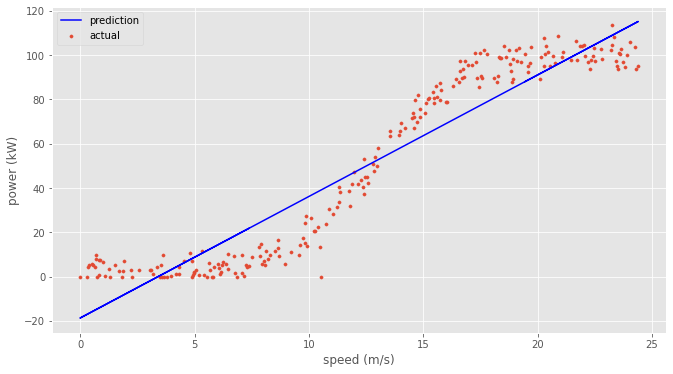

In [17]:
# Use model to make predictions
prediction = reg.predict(A_Test)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, prediction, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

We can see clearly that a straight line does not fit the data very well. For certain predictive models, an R-squared value of ~0.90 might be considered a satisfactory score. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.

#### Outlier vs no outlier
Before moving to the next section, let us briefly create a model with the original data set (prior to outlier removal) in order to demonstrate the impact of dropping outliers from the data set:

When the model is trained using the original data set, we can see that there is a significant drop in the score. (~0.74 vs ~0.90). This demonstrates the importance of outlier removal, if appropriate.

<br>

### 3.3 Polynomial regression

***

Visualising the plot above, we can see that the straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using `LinearRegression` just as above. The code for this is based on an informative towardsdatascience.com blog post [28].

<br>



First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fitted to the model and predictions are made based on the test data. 

In [119]:

A_Train2, A_Test2, B_Train2, B_Test2 = train_test_split(pp_clean.speed, pp_clean.power, test_size = 0.2, random_state=1)

In [120]:
# Convert train and test subsets to numpy arrays
poly_speed_train = A_Train2.to_numpy().reshape(-1, 1)
poly_power_train = B_Train2.to_numpy().reshape(-1, 1)
poly_speed_test  = A_Test2.to_numpy().reshape(-1, 1)
poly_power_test = B_Test2.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

In [121]:
# Calculate mean squared error 
mse_test = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2_test = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse_test, r2_test

(18.30473912370965, 0.9892671550780056)

With an R-Squared value of ~0.99 we can see that polynomial regression performs significantly better than the simple linear regression above.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely:

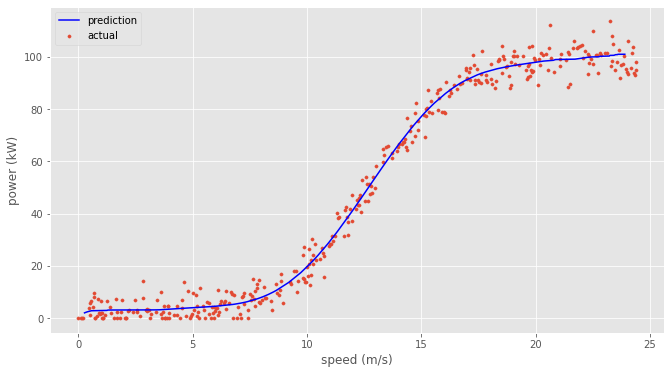

In [21]:
# Plot on scatterplot
plt.scatter(poly_speed_train, poly_power_train, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

<br>

Next, I call the `intercept_` method to determine where the line intercepts the y-axis. And below that I use call `coef_` to get the slope of the line. This gives us all the values for formula for the best-fitting line: $$y = mx + b$$ where m is the slope, b is the y-interept and x is the independent variable [3].

[3] dummies.com; How to calculate a regression line; https://www.dummies.com/education/math/statistics/how-to-calculate-a-regression-line/ <br>

In [26]:
# Call the intercept_ method to determine where the line intercepts the y-axis
reg.intercept_

array([-18.67136645])

In [27]:
# Call the coef_ method to calculate the slope of the line
reg.coef_

array([[5.48508889]])

In [28]:
# Set calculated values
m = 4.91759567
x = 9.746
b = -13.899902630519641

y = m*x + b
print(y)

34.02698476930036


As expected, we get the same result for y when we input these values into the formula (above)
<br>



In [29]:
# Calculate R-squared value
reg.score(speed_df, power_df)

0.9006649798244997

<br>


***

In [30]:
x

9.746

## Neural network - Regression

***

In [31]:
#pp = pp[pp.power != 0]
#pp.describe()

In [32]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [33]:
model = create_model()

In [34]:


msk = np.random.rand(len(pp_clean2)) < 0.5
train = pp_clean2[msk]

test = pp_clean2[~msk]

In [35]:
model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

Epoch 1/500
25/25 [==============================] - 1s 3ms/step - loss: 3906.8607
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 2283.7497
Epoch 3/500
25/25 [==============================] - 0s 3ms/step - loss: 922.7230
Epoch 4/500
25/25 [==============================] - 0s 3ms/step - loss: 293.9726
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 279.6616
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 252.1573
Epoch 7/500
25/25 [==============================] - 0s 3ms/step - loss: 261.8559
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 228.4088
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 236.6818
Epoch 10/500
25/25 [==============================] - 0s 3ms/step - loss: 244.4741
Epoch 11/500
25/25 [==============================] - 0s 2ms/step - loss: 259.8511
Epoch 12/500
25/25 [==============================] - 0s 3ms/step - loss: 189.0895
Epoch 13/50

25/25 [==============================] - 0s 3ms/step - loss: 80.4690
Epoch 101/500
25/25 [==============================] - 0s 2ms/step - loss: 73.8327
Epoch 102/500
25/25 [==============================] - 0s 2ms/step - loss: 75.4882
Epoch 103/500
25/25 [==============================] - 0s 3ms/step - loss: 78.6612
Epoch 104/500
25/25 [==============================] - 0s 2ms/step - loss: 69.4147
Epoch 105/500
25/25 [==============================] - 0s 3ms/step - loss: 60.5656
Epoch 106/500
25/25 [==============================] - 0s 2ms/step - loss: 73.6112
Epoch 107/500
25/25 [==============================] - 0s 3ms/step - loss: 76.4656
Epoch 108/500
25/25 [==============================] - 0s 3ms/step - loss: 83.3628
Epoch 109/500
25/25 [==============================] - 0s 3ms/step - loss: 80.9325
Epoch 110/500
25/25 [==============================] - 0s 3ms/step - loss: 80.3038
Epoch 111/500
25/25 [==============================] - 0s 2ms/step - loss: 72.2219
Epoch 112/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 46.2391
Epoch 199/500
25/25 [==============================] - 0s 3ms/step - loss: 47.5536
Epoch 200/500
25/25 [==============================] - 0s 3ms/step - loss: 45.4051
Epoch 201/500
25/25 [==============================] - 0s 3ms/step - loss: 44.1051
Epoch 202/500
25/25 [==============================] - 0s 3ms/step - loss: 32.5489
Epoch 203/500
25/25 [==============================] - 0s 3ms/step - loss: 42.7563
Epoch 204/500
25/25 [==============================] - 0s 3ms/step - loss: 45.5187
Epoch 205/500
25/25 [==============================] - 0s 2ms/step - loss: 40.1486
Epoch 206/500
25/25 [==============================] - 0s 3ms/step - loss: 53.6448
Epoch 207/500
25/25 [==============================] - 0s 2ms/step - loss: 42.7099
Epoch 208/500
25/25 [==============================] - 0s 3ms/step - loss: 45.3915
Epoch 209/500
25/25 [==============================] - 0s 3ms/step - loss: 48.6960
Epoch 210/500
25/2

25/25 [==============================] - 0s 2ms/step - loss: 21.9090
Epoch 297/500
25/25 [==============================] - 0s 2ms/step - loss: 25.7505
Epoch 298/500
25/25 [==============================] - 0s 3ms/step - loss: 27.5048
Epoch 299/500
25/25 [==============================] - 0s 3ms/step - loss: 33.8247
Epoch 300/500
25/25 [==============================] - 0s 3ms/step - loss: 23.4063
Epoch 301/500
25/25 [==============================] - 0s 2ms/step - loss: 23.7716
Epoch 302/500
25/25 [==============================] - 0s 2ms/step - loss: 29.7545
Epoch 303/500
25/25 [==============================] - 0s 3ms/step - loss: 23.6213
Epoch 304/500
25/25 [==============================] - 0s 3ms/step - loss: 28.5462
Epoch 305/500
25/25 [==============================] - 0s 3ms/step - loss: 22.4958
Epoch 306/500
25/25 [==============================] - 0s 3ms/step - loss: 20.1329
Epoch 307/500
25/25 [==============================] - 0s 2ms/step - loss: 21.7757
Epoch 308/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 22.5981
Epoch 395/500
25/25 [==============================] - 0s 3ms/step - loss: 16.5436
Epoch 396/500
25/25 [==============================] - 0s 3ms/step - loss: 16.7702
Epoch 397/500
25/25 [==============================] - 0s 3ms/step - loss: 20.2336
Epoch 398/500
25/25 [==============================] - 0s 3ms/step - loss: 21.7362
Epoch 399/500
25/25 [==============================] - 0s 3ms/step - loss: 16.1941
Epoch 400/500
25/25 [==============================] - 0s 2ms/step - loss: 17.6956
Epoch 401/500
25/25 [==============================] - 0s 3ms/step - loss: 17.5384
Epoch 402/500
25/25 [==============================] - 0s 3ms/step - loss: 18.4773
Epoch 403/500
25/25 [==============================] - 0s 2ms/step - loss: 19.1093
Epoch 404/500
25/25 [==============================] - 0s 2ms/step - loss: 18.5695
Epoch 405/500
25/25 [==============================] - 0s 2ms/step - loss: 18.1196
Epoch 406/500
25/2

25/25 [==============================] - 0s 2ms/step - loss: 16.2768
Epoch 493/500
25/25 [==============================] - 0s 2ms/step - loss: 15.4919
Epoch 494/500
25/25 [==============================] - 0s 3ms/step - loss: 18.5780
Epoch 495/500
25/25 [==============================] - 0s 2ms/step - loss: 17.9234
Epoch 496/500
25/25 [==============================] - 0s 3ms/step - loss: 18.3615
Epoch 497/500
25/25 [==============================] - 0s 3ms/step - loss: 21.0616
Epoch 498/500
25/25 [==============================] - 0s 3ms/step - loss: 21.2690
Epoch 499/500
25/25 [==============================] - 0s 2ms/step - loss: 18.3770
Epoch 500/500
25/25 [==============================] - 0s 2ms/step - loss: 18.0656


In [36]:
shapes = model.predict(test['speed'])

In [37]:
shapes.shape

(245, 1)

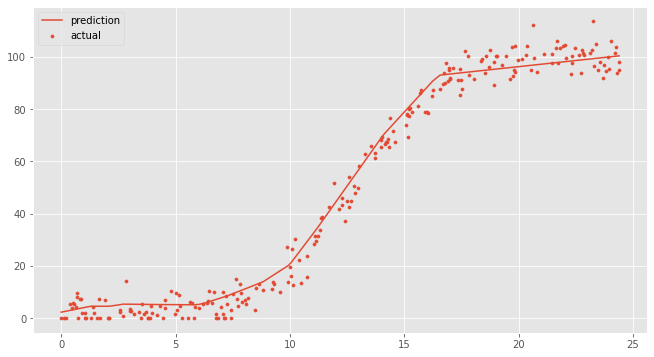

In [38]:
plt.scatter(test['speed'], test['power'], label='actual', s=10)
plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
plt.legend()

In [39]:
model.fit(A_Train, B_Train, epochs=500, batch_size=10)

Epoch 1/500
25/25 [==============================] - 1s 4ms/step - loss: 16.9338
Epoch 2/500
25/25 [==============================] - 0s 4ms/step - loss: 17.1545
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 16.6973
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 16.2550
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 17.2669
Epoch 6/500
25/25 [==============================] - 0s 4ms/step - loss: 18.9488
Epoch 7/500
25/25 [==============================] - 0s 4ms/step - loss: 17.3249
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 18.4233
Epoch 9/500
25/25 [==============================] - 0s 4ms/step - loss: 16.6693
Epoch 10/500
25/25 [==============================] - 0s 4ms/step - loss: 16.9603
Epoch 11/500
25/25 [==============================] - 0s 4ms/step - loss: 18.8096
Epoch 12/500
25/25 [==============================] - 0s 4ms/step - loss: 16.5010
Epoch 13/500
25/25 [=====

25/25 [==============================] - 0s 4ms/step - loss: 18.1797
Epoch 102/500
25/25 [==============================] - 0s 4ms/step - loss: 17.1053
Epoch 103/500
25/25 [==============================] - 0s 4ms/step - loss: 17.8416
Epoch 104/500
25/25 [==============================] - 0s 3ms/step - loss: 16.1363
Epoch 105/500
25/25 [==============================] - 0s 4ms/step - loss: 16.3589
Epoch 106/500
25/25 [==============================] - 0s 3ms/step - loss: 16.5853
Epoch 107/500
25/25 [==============================] - 0s 4ms/step - loss: 16.3474
Epoch 108/500
25/25 [==============================] - 0s 4ms/step - loss: 16.4229
Epoch 109/500
25/25 [==============================] - 0s 4ms/step - loss: 16.9794
Epoch 110/500
25/25 [==============================] - 0s 4ms/step - loss: 16.5274
Epoch 111/500
25/25 [==============================] - 0s 4ms/step - loss: 15.1192
Epoch 112/500
25/25 [==============================] - 0s 3ms/step - loss: 16.0331
Epoch 113/500
25/2

25/25 [==============================] - 0s 4ms/step - loss: 19.9533
Epoch 200/500
25/25 [==============================] - 0s 4ms/step - loss: 17.9573
Epoch 201/500
25/25 [==============================] - 0s 3ms/step - loss: 15.4561
Epoch 202/500
25/25 [==============================] - 0s 3ms/step - loss: 15.7145
Epoch 203/500
25/25 [==============================] - 0s 3ms/step - loss: 17.3032
Epoch 204/500
25/25 [==============================] - 0s 3ms/step - loss: 17.3279
Epoch 205/500
25/25 [==============================] - 0s 3ms/step - loss: 16.2000
Epoch 206/500
25/25 [==============================] - 0s 4ms/step - loss: 17.1423
Epoch 207/500
25/25 [==============================] - 0s 3ms/step - loss: 15.3162
Epoch 208/500
25/25 [==============================] - 0s 4ms/step - loss: 16.9408
Epoch 209/500
25/25 [==============================] - 0s 4ms/step - loss: 16.8660
Epoch 210/500
25/25 [==============================] - 0s 4ms/step - loss: 16.0480
Epoch 211/500
25/2

25/25 [==============================] - 0s 4ms/step - loss: 15.7590
Epoch 298/500
25/25 [==============================] - 0s 4ms/step - loss: 17.1138
Epoch 299/500
25/25 [==============================] - 0s 3ms/step - loss: 16.5992
Epoch 300/500
25/25 [==============================] - 0s 4ms/step - loss: 15.3061
Epoch 301/500
25/25 [==============================] - 0s 3ms/step - loss: 19.3846
Epoch 302/500
25/25 [==============================] - 0s 3ms/step - loss: 15.9396
Epoch 303/500
25/25 [==============================] - 0s 3ms/step - loss: 15.5183
Epoch 304/500
25/25 [==============================] - 0s 3ms/step - loss: 16.7906
Epoch 305/500
25/25 [==============================] - 0s 3ms/step - loss: 15.3974
Epoch 306/500
25/25 [==============================] - 0s 4ms/step - loss: 15.7856
Epoch 307/500
25/25 [==============================] - 0s 4ms/step - loss: 16.5453
Epoch 308/500
25/25 [==============================] - 0s 3ms/step - loss: 15.5528
Epoch 309/500
25/2

25/25 [==============================] - 0s 4ms/step - loss: 15.6638
Epoch 396/500
25/25 [==============================] - 0s 4ms/step - loss: 16.0422
Epoch 397/500
25/25 [==============================] - 0s 5ms/step - loss: 16.7017
Epoch 398/500
25/25 [==============================] - 0s 4ms/step - loss: 16.6584
Epoch 399/500
25/25 [==============================] - 0s 4ms/step - loss: 17.2728
Epoch 400/500
25/25 [==============================] - 0s 3ms/step - loss: 16.3151
Epoch 401/500
25/25 [==============================] - 0s 3ms/step - loss: 16.6823
Epoch 402/500
25/25 [==============================] - 0s 4ms/step - loss: 16.0077
Epoch 403/500
25/25 [==============================] - 0s 4ms/step - loss: 15.6060
Epoch 404/500
25/25 [==============================] - 0s 4ms/step - loss: 15.6645
Epoch 405/500
25/25 [==============================] - 0s 3ms/step - loss: 15.7157
Epoch 406/500
25/25 [==============================] - 0s 3ms/step - loss: 17.0912
Epoch 407/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 14.7141
Epoch 494/500
25/25 [==============================] - 0s 3ms/step - loss: 17.3380
Epoch 495/500
25/25 [==============================] - 0s 3ms/step - loss: 15.5439
Epoch 496/500
25/25 [==============================] - 0s 4ms/step - loss: 17.1784
Epoch 497/500
25/25 [==============================] - 0s 3ms/step - loss: 15.5787
Epoch 498/500
25/25 [==============================] - 0s 3ms/step - loss: 16.1884
Epoch 499/500
25/25 [==============================] - 0s 4ms/step - loss: 16.2269
Epoch 500/500
25/25 [==============================] - 0s 3ms/step - loss: 15.4838


In [40]:
nn_predict = model.predict(A_Test)

nn_predict.shape

(244, 1)

In [41]:
arr_sort = np.sort(nn_predict, axis=0)

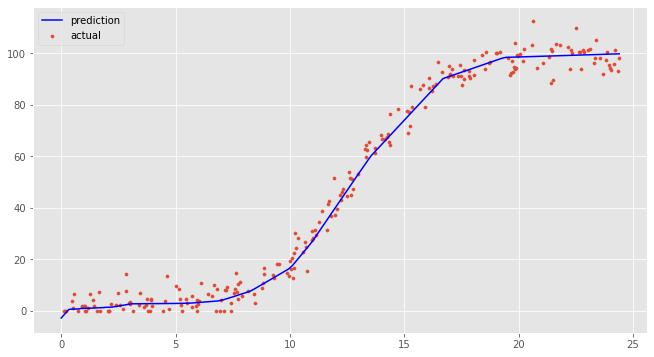

In [42]:
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(A_Test, axis=0)

plt.scatter(A_Train, B_Train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [44]:
# model.save('my_model.h5')

In [45]:
model.predict([14])

array([[64.50367]], dtype=float32)

In [46]:
r3_test = r2_score(A_Test, nn_predict)
mse3_test = mean_squared_error(A_Test, nn_predict)

In [47]:
r3_test, mse3_test

(-63.431823740518766, 3214.8614801368444)

In [48]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_clean2.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]
# define base model
def baseline_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)


Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 4214.8792
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 4660.2587
Epoch 3/300
44/44 [==============================] - 0s 3ms/step - loss: 4405.4057
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 3839.2543
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 3298.4742
Epoch 6/300
44/44 [==============================] - 0s 2ms/step - loss: 3309.5295
Epoch 7/300
44/44 [==============================] - 0s 3ms/step - loss: 2978.5958
Epoch 8/300
44/44 [==============================] - 0s 2ms/step - loss: 2842.8306
Epoch 9/300
44/44 [==============================] - 0s 3ms/step - loss: 2652.5682
Epoch 10/300
44/44 [==============================] - 0s 2ms/step - loss: 2360.1897
Epoch 11/300
44/44 [==============================] - 0s 2ms/step - loss: 2291.6172
Epoch 12/300
44/44 [==============================] - 0s 3ms/step - loss: 2066.4918
E

44/44 [==============================] - 0s 2ms/step - loss: 32.4273
Epoch 101/300
44/44 [==============================] - 0s 3ms/step - loss: 28.6935
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 30.3705
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 29.5685
Epoch 104/300
44/44 [==============================] - 0s 3ms/step - loss: 30.0135
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 28.8944
Epoch 106/300
44/44 [==============================] - 0s 2ms/step - loss: 28.3037
Epoch 107/300
44/44 [==============================] - 0s 2ms/step - loss: 27.0586
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 28.6342
Epoch 109/300
44/44 [==============================] - 0s 2ms/step - loss: 26.0340
Epoch 110/300
44/44 [==============================] - 0s 2ms/step - loss: 30.0791
Epoch 111/300
44/44 [==============================] - 0s 3ms/step - loss: 29.3453
Epoch 112/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.1040
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6092
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3000
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7187
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9020
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3745
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7297
Epoch 205/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7942
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8298
Epoch 207/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2446
Epoch 208/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6285
Epoch 209/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2629
Epoch 210/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 17.5630
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4879
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6948
Epoch 299/300
44/44 [==============================] - 0s 3ms/step - loss: 18.9014
Epoch 300/300
5/5 [==============================] - 0s 0s/step - loss: 10.7769
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4833.8254
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 4368.1951
Epoch 3/300
44/44 [==============================] - 0s 3ms/step - loss: 4373.7635
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 4221.5900
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 3805.8674
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 3521.5363
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 3435.6721
Epoch 8/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 34.5811
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 38.8434
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 36.6905
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 37.7460
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 33.5602
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 37.1376
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 30.4391
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 33.5633
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 30.9266
Epoch 103/300
44/44 [==============================] - 0s 3ms/step - loss: 30.3070
Epoch 104/300
44/44 [==============================] - 0s 3ms/step - loss: 29.7748
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 34.0556
Epoch 106/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 20.2528
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6192
Epoch 194/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5213
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5153
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7263
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7803
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7526
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8933
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8241
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2716
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3101
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9860
Epoch 204/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 18.0796
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4939
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9830
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4421
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9167
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2005
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4856
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4864
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4460
Epoch 299/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2983
Epoch 300/300
5/5 [==============================] - 0s 0s/step - loss: 17.5420
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4587.3254
Epoch 2/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 44.9903
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 43.5652
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 44.1782
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 43.6739
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 42.3292
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 44.3250
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 44.0134
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 44.6876
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 40.0387
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 42.6446
Epoch 98/300
44/44 [==============================] - 0s 3ms/step - loss: 40.2568
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 38.3706
Epoch 100/300
44/44 [========

44/44 [==============================] - 0s 3ms/step - loss: 19.7023
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1792
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1282
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4604
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0271
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0066
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4419
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9079
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5635
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5470
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5653
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7292
Epoch 199/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.5964
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7134
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5739
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9375
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3978
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4486
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7385
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8291
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3519
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4277
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8409
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2627
Epoch 297/300
44/4

Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 39.7764
Epoch 84/300
44/44 [==============================] - 0s 3ms/step - loss: 38.3942
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 45.8158
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 37.8824
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 40.9718
Epoch 88/300
44/44 [==============================] - 0s 3ms/step - loss: 38.3809
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 44.7128
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 39.8317
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 43.3642
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 35.9246
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 37.0842
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 38.0975
Epoch 95/300
44/

44/44 [==============================] - 0s 2ms/step - loss: 21.2620
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 20.0958
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4213
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 21.4623
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8128
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9673
Epoch 187/300
44/44 [==============================] - 0s 3ms/step - loss: 19.1534
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9492
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 21.0987
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3663
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1480
Epoch 192/300
44/44 [==============================] - 0s 3ms/step - loss: 18.9361
Epoch 193/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.7858
Epoch 280/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2436
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3650
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8303
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8484
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6399
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5294
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8039
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2091
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7412
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5946
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2102
Epoch 291/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 54.8457
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 50.2957
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 51.1426
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 54.9136
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 52.7300
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 48.0020
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 49.5163
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 43.3770
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 43.4347
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 46.0228
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 44.3908
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 41.6083
Epoch 89/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 20.1728
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2594
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 21.0335
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3793
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 21.1857
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3117
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7878
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3927
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 19.1402
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9681
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3461
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 20.8207
Epoch 187/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 17.3379
Epoch 274/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1799
Epoch 275/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4007
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1276
Epoch 277/300
44/44 [==============================] - 0s 3ms/step - loss: 15.0566
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 14.4724
Epoch 279/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8204
Epoch 280/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8577
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3077
Epoch 282/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9681
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8857
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7880
Epoch 285/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 60.9282
Epoch 72/300
44/44 [==============================] - 0s 3ms/step - loss: 61.7921
Epoch 73/300
44/44 [==============================] - 0s 3ms/step - loss: 55.3896
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 53.7942
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 54.2702
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 62.0553
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 56.8333
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 49.5920
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 52.5078
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 53.9927
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 47.8363
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 50.0092
Epoch 83/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 21.6333
Epoch 170/300
44/44 [==============================] - 0s 3ms/step - loss: 20.4888
Epoch 171/300
44/44 [==============================] - 0s 3ms/step - loss: 21.1899
Epoch 172/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2641
Epoch 173/300
44/44 [==============================] - 0s 3ms/step - loss: 20.1550
Epoch 174/300
44/44 [==============================] - 0s 3ms/step - loss: 20.0387
Epoch 175/300
44/44 [==============================] - 0s 3ms/step - loss: 19.1319
Epoch 176/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3411
Epoch 177/300
44/44 [==============================] - 0s 3ms/step - loss: 19.3564
Epoch 178/300
44/44 [==============================] - 0s 3ms/step - loss: 19.5419
Epoch 179/300
44/44 [==============================] - 0s 3ms/step - loss: 19.6922
Epoch 180/300
44/44 [==============================] - 0s 3ms/step - loss: 19.6617
Epoch 181/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.8389
Epoch 268/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5194
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3277
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4104
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2107
Epoch 272/300
44/44 [==============================] - 0s 3ms/step - loss: 18.9439
Epoch 273/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5718
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0126
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7137
Epoch 276/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1225
Epoch 277/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7822
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9792
Epoch 279/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 63.0201
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 60.1358
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 60.0499
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 62.1223
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 58.7045
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 56.8836
Epoch 71/300
44/44 [==============================] - 0s 3ms/step - loss: 56.0347
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 63.3122
Epoch 73/300
44/44 [==============================] - 0s 3ms/step - loss: 50.7030
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 52.4213
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 53.3341
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 46.8532
Epoch 77/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 19.9465
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9971
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1071
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 20.0376
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3870
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 21.3498
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7087
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3456
Epoch 172/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7403
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 20.7712
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5976
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0892
Epoch 176/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.1559
Epoch 263/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2417
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8435
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9734
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7098
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3665
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9764
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7413
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2041
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3113
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3896
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7592
Epoch 274/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 83.9355
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 91.1941
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 79.1124
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 77.7066
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 68.6471
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 70.1191
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 67.6419
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 66.6268
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 68.2190
Epoch 69/300
44/44 [==============================] - 0s 3ms/step - loss: 63.3876
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 63.0360
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 58.5962
Epoch 72/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 18.5250
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3610
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2618
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4433
Epoch 163/300
44/44 [==============================] - 0s 3ms/step - loss: 18.6744
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1456
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4916
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7489
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7465
Epoch 168/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0530
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4349
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3806
Epoch 171/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.5431
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8651
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5410
Epoch 260/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8243
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1584
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1096
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1197
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8615
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2288
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6830
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1634
Epoch 268/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1247
Epoch 269/300
44/4

Epoch 55/300
44/44 [==============================] - 0s 2ms/step - loss: 100.4072
Epoch 56/300
44/44 [==============================] - 0s 2ms/step - loss: 89.0234
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 96.1740
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 84.8260
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 81.9827
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 80.7247
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 76.4837
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 72.6495
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 73.7740
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 69.6736
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 63.8691
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 60.2024
Epoch 67/300
44

44/44 [==============================] - 0s 2ms/step - loss: 18.6706
Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 22.7055
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6744
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9213
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1682
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 21.3232
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5916
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3349
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6386
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4246
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3893
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7356
Epoch 166/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.8870
Epoch 253/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3579
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3992
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8807
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1367
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1875
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4358
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8720
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2983
Epoch 261/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2271
Epoch 262/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5919
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7301
Epoch 264/300
44/4

Epoch 50/300
44/44 [==============================] - 0s 2ms/step - loss: 137.4128
Epoch 51/300
44/44 [==============================] - 0s 2ms/step - loss: 116.5482
Epoch 52/300
44/44 [==============================] - 0s 2ms/step - loss: 124.3439
Epoch 53/300
44/44 [==============================] - 0s 2ms/step - loss: 121.1882
Epoch 54/300
44/44 [==============================] - 0s 2ms/step - loss: 100.3016
Epoch 55/300
44/44 [==============================] - 0s 2ms/step - loss: 101.2676
Epoch 56/300
44/44 [==============================] - 0s 2ms/step - loss: 91.6914
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 84.3589
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 81.5881
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 74.8256
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 78.5095
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 71.4585
Epoch 62/3

44/44 [==============================] - 0s 2ms/step - loss: 19.7532
Epoch 150/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5567
Epoch 151/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4271
Epoch 152/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2567
Epoch 153/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5750
Epoch 154/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2924
Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3366
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8550
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3848
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4727
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0122
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2093
Epoch 161/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.7193
Epoch 248/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3374
Epoch 249/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5001
Epoch 250/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7207
Epoch 251/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5487
Epoch 252/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2220
Epoch 253/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1781
Epoch 254/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0325
Epoch 255/300
44/44 [==============================] - 0s 3ms/step - loss: 15.3809: 0s - loss: 15.23
Epoch 256/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1200
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7943
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9536


In [49]:
# 1 layer, sigmoid, 200 epochs, lr=0.01
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std())) 

Standardized: -17.64 (4.37) MSE


In [50]:
# 1 layer, sigmoid, 100 epochs, lr=0.01
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.64 (4.37) MSE


In [51]:
# 2 layers, relu and relu, 500, lr=0.001
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.64 (4.37) MSE


In [52]:
# 1 layer, sigmoid, 300 epochs, lr=0.01
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.64 (4.37) MSE


In [53]:
# 1 layer, sigmoid, 300 epochs, lr=0.001
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.64 (4.37) MSE


In [54]:
len(X)

486

In [55]:
ep_100 = 25
ep_500_10 = 23.87

In [56]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

10.120437473614711
0.8537647164420812


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())

print(model2.score(A_Train, B_Train))

print(model2.score(A_Test, B_Test))
pred = model2.predict(A_Test)
pred = np.sort(pred, 0)

In [ ]:

from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())
model3.score(A_Train, B_Train)

model3.score(A_Test, B_Test)
pred2 = model3.predict(A_Test)
pred2 = np.sort(pred2, 0)

In [ ]:
# # Use model to make predictions
# pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, pred2, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>